In [2]:
#"Importing" SSOR

#SSOR
#Same method but with a forward and backwards SOR

import numpy as np

def SORit(A,u,w,f):
    N = np.size(u)
    s0 = u[0]
    u[0] = (f[0] - np.dot(A[0,1:],u[1:]))/A[0,0]  #First step manually
    u[0] = (1-w)*s0+w*u[0]
    for i in range(1,N-1): #Do N-2 steps automatically following algorithm
        s = u[i]
        u[i] = (f[i]-np.dot(A[i,:i],u[:i])-np.dot(A[i,i+1:],u[i+1:]))/A[i,i]
        u[i] = (1-w)*s+w*u[i]
    sN = u[-1] #Do last step manually
    u[-1] = (f[-1]-np.dot(A[-1,:-1],u[:-1]))/A[-1,-1]
    u[-1] = (1-w)*sN+w*u[-1]
    return u

def SORBWit(A,u,w,f): 
    N = np.size(u)
    sN = u[-1] #Do last step manually
    u[-1] = (f[-1]-np.dot(A[-1,:-1],u[:-1]))/A[-1,-1]
    u[-1] = (1-w)*sN+w*u[-1]
    for i in reversed(range(1,N-1)): #Do N-2 steps automatically following algorithm but reversed
        s = u[i]
        u[i] = (f[i]-np.dot(A[i,:i],u[:i])-np.dot(A[i,i+1:],u[i+1:]))/A[i,i]
        u[i] = (1-w)*s+w*u[i]
    s0 = u[0]
    u[0] = (f[0] - np.dot(A[0,1:],u[1:]))/A[0,0]  #First step manually
    u[0] = (1-w)*s0+w*u[0]
    return u

def SSOR(A,u,w,f,N):
    u0 = u
    for i in range(N):
        u0 = SORit(A,u0,w,f)
        u0 = SORBWit(A,u0,w,f)
    return u0

In [3]:
#Creating A,f,u_ex

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as la
import matplotlib.ticker as ticker

def sourcefunc(x,y):
    f = (x**2 + y**2)*np.sin(x*y)
    return f

def boundary(x,y):
    b = np.sin(x*y)
    return b

def create_Afuex_2D(sourcefunc, boundary, p):

    # Here I create the T_h and I_h matrices. These have precisely the same form as in the lecture notes. Some manual
    # stuff is done since we are working without elimination of boundary conditions
    h = 1/(2**p)
    N = 1/h
    N = int(N)
    Th = sp.diags([-1, 2, -1], [-1, 0, 1], shape=(N-1, N-1)).toarray()
    T_h = np.pad(Th,1)
    T_h[0,0] = h**2
    T_h[N,N] = h**2
    Ih = sp.diags([1],[0], shape=(N-1, N-1)).toarray()
    I_h = np.pad(Ih,1)
    # The final A_h matrix is construced here. Because of the h^2 * I_{N+1} identity matrix in the very top left 
    # corner and bottom right corner I have to change four values manually from zero to 1
    A = (1/(h**2))*np.kron(T_h, I_h) + (1/(h**2))*np.kron(I_h, T_h)
    A[0,0] = 1
    A[N,N] = 1
    A[(N+1)**2-N-1,(N+1)**2-N-1] = 1
    A[(N+1)**2-1,(N+1)**2-1] = 1
    
    
    # A meshgrid is created here on which I will evalute the source function. This vector is the right size for
    # the final result, but it includes every boundary value also, as evaluated through f. This is obviously wrong
    # as these boundary values should be evaluated through b, so that has to be adjusted. I therefore immediately 
    # introduce b1 and b_end as vectors which are the boundary values on the bottom and top of the grid, respectively.
    # f is also reshaped here to be a vector, not an array.
    x,y = np.mgrid[0: 1: complex(0, N+1), 0: 1: complex(0, N+1)]
    x = x.transpose()
    y = y.transpose()

    f = sourcefunc(x,y)
    f = np.reshape(f, (N+1)*(N+1))

    x_axis = np.linspace(0, 1, num = N+1)
    b1 = boundary(x_axis, 0)
    b_end = boundary(x_axis, 1)
    
    # In this section I overwrite the parts of the f vector that represent boundary terms and next-to-boundary terms.
    # In the first loop I overwrite the firts and last parts of f with b1 and b_end, so that the bottom and top of the 
    # 'grid' are boundary values. In the second loop I overwrite values representing the left and right side of the
    # 'grid'. Of course the bottom and left boundaries are just filled with zeros, as sin(xy) is zero when either x
    # or y is zero. In the third loop I overwrite the entries which represent positions next to the right boundary. In
    # the last loop I overwrite the entries which represent positions right below the top boundary. 


    for i in range(0, N+1):
        f[i] = b1[i]
        f[(N+1)*N + i] = b_end[i]

    for i in range(1,N):
        f[i*(N+1)] = 0
        f[i*(N+1)+ N] = boundary(1, i*h)
    
    for i in range(0,N-1):    
        f[2*N+i*(N+1)] = f[2*N+i*(N+1)] + boundary(1, (i+1)*h)/(h**2)
    
    for i in range(0,N-1):     
        f[(N+1)**2-1-2*N+i] = f[(N+1)**2-1-2*N+i] + b_end[i+1]/(h**2)
        
    u_ex_pre = boundary(x,y)
    u_ex = np.reshape(u_ex_pre, (1, (N+1)*(N+1)))
        
    return A , f , u_ex



In [15]:
#Create A,f,u_ex for various sizes
data = []
for i in range(2,8):
    A,f,u_ex = create_Afuex_2D(sourcefunc, boundary, i)
    data.append((A,f,u_ex))

In [24]:
import time
N = 100   #Max number of iterations

errorvec = np.zeros(N)
timevec = np.zeros(N)
itevec = np.linspace(1,N,N)

p = 5

A = data[p-2][0]
f = data[p-2][1]
u_ex = data[p-2][2]

for i in range(N):
    u0 = np.zeros(np.size(f))
    t = time.time()
    u = SSOR(A,u0,1.5,f,i)
    t = time.time()-t
    timevec[i] = t
    error = np.amax(np.absolute(u_ex-u))
    errorvec[i] = error


0.0015973207162426895


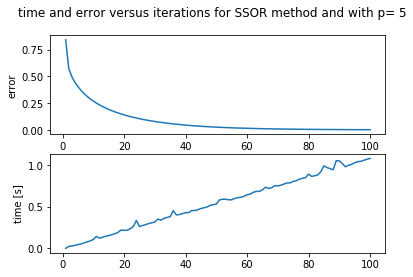

In [30]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(2)
fig.suptitle('time and error versus iterations for SSOR method and with p= 5')
axs[0].plot(itevec, errorvec)
axs[0].set(ylabel="error")
axs[1].plot(itevec, timevec)
axs[1].set(ylabel="time [s]")

print(errorvec[N-1])

In [ ]:
#Solve for SSOR with omega = 1.5

for i in data:
    t = time.time()
    u = SSOR(i[0],u0,1.5,i[1],)
    u = DirSolver(i[0],i[1])
    t = time.time()-t
    error = np.amax(np.absolute(i[2]-u))
    print("Error: ", error, "time: ", t)

In [14]:
for i in range(2,7):
    print(i)

2
3
4
5
6
